# Case Study: Ocean Health Indicators in Folger Passage

In this coding workbook we will combine real-world data science with ocean monitoring to explore the health of the local ecosystem. In this case study, we’ll focus on Folger Passage, located in the Bamfield region on the west coast of Vancouver Island, within Huu-ay-aht ḥahuułi (territory). See the map below to situate yourself in this region. This area is home to two key Ocean Networks Canada (ONC) observatories: Folger Deep (station code: FGPD) and Folger Pinnacle (station code: FGPPN). 

<img src="Folger-Passage-Overview.png" width="" align="" />

See the figures below for more information on the two major stations in Folgers Passage, Folger Deep and Folger Passage. Note one of the graphics displays the sensors available at each station while the other gives you a depth perspective using a profile view. 

![Folger Neptune Map](https://cdn.onc-prod.intergalactic.space/folgerpassage_300dpi_ff2a03c373.jpg)

Folger Passage overview, including the sensors available at Folger Deep and Folger Pinnacle.

<img src="folger-passage-bathymetry.jpg" width="" align="" />

A profile view of the Folger Deep and Folger Pinnacle stations, giving a perspective of the difference in depth between the two stations.

Using the ONC API, you’ll learn how to programmatically access and work with oceanographic data collected from these underwater stations. We’ll walk through how to retrieve and visualize datasets, with a focus on a low oxygen event that occurred in August 2021. This workbook was inspired by the work of Franco et al., 2023 titled Drivers and Potential Consequences of Observed Extreme Hypoxia Along the Canadian Pacific Continental Shelf (https://doi.org/10.1029/2022GL101857). This is a key local example of how environmental events can be detected and interpreted using real-time ocean data.

By the end of this workbook, you’ll have hands-on experience in:

- Using your token to connect to the ONC API

- Accessing and filtering ocean sensor data

- Exploring physical and biogeochemical trends

- Interpreting ocean health indicators in a real-world context

Let’s dive in!

Key words: library, variable, input/parameter, API, token, query, function, data frame

## 1. Set up programming environment

The code below installs the ONC, pandas, matplotlib, plotly and cmocean libraries. These libraries contain external code that add extra features to Python. When we install a library the code is placed on to your system where it can be found and used by Python.

In [1]:
!pip install onc         # Installs the ONC Python client to access Ocean Networks Canada data via their public API
!pip install pandas      # Installs pandas, a powerful data analysis and manipulation library that uses DataFrames
!pip install matplotlib  # Installs matplotlib, a widely used plotting library for creating static and animated visualizations
!pip install plotly      # Installs Plotly, a library for creating interactive, web-based plots and dashboards
!pip install cmocean     # Installs cmocean, a set of colormaps tailored for oceanographic data visualization


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 33.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Next, we import from these libraries. When we import a library, it loads the installed code into our program so that we can use it in this notebook.

Some of the libraries we use help us accomplish tasks like connecting to online data sources (e.g. ONC's client library), performing data analysis (e.g. Pandas) or making plots (e.g. Matplotlib).

In [2]:
import onc # ONC client library
import pandas as pd # library to make data frames and datetime objects

## 2. Plotting one year of data - Folger Deep and Pinnacle

Now that our basic environment is set up, we can start programming.

### 2.1 Define parameters to query (request) from ONC's database

In the code block below, we define the parameters that form the query we want to ask the API.

An API (Application Programming Interface) is a sort of middle man between your code and a database. The ONC API will deliver your questions to the ONC database and in turn deliver the data response back to you.

A query, or request, is the what we call your question, and is made up of your input parameters.

Input parameters are details that you need to provide the API so that it understands the data you want to ask for. In our case, that means things like location, date range, and sensor properties. 

We define our parameters according to what we are interested in. At Folger deep, we are interested in oxygen, salinity, seawater temperature, density and sigma -t. At Folger pinnacle, we are interested in oxygen, chlorophyll a, salinity, turbidity, seawater temperature, density and sigma-t.  

In [3]:
# Time frame - the year of 2021
start_21 = "2021-01-01T00:00:00.000Z"
start_22 = "2022-01-01T00:00:00.000Z"

# Properties available at Folger Deep and Folger Pinnacle
# See documentation - https://wiki.oceannetworks.ca/x/2w7nAg
deep_properties = ["oxygen", "salinity", "seawatertemperature", "density", "sigmat"]
pinnacle_properties = ["oxygen", "salinity", "seawatertemperature", "density", "sigmat", "chlorophyll", "turbidityntu"]

# Location Codes for Deep and Pinnacle
# See documentation - https://wiki.oceannetworks.ca/x/gYLyAg
deep_locationCode = "FGPD" 
pinnacle_locationCode = "FGPPN"

# Resample (necessary for time series greater than 1 day)
resample = 1800 # Sets subsampling period for every 1800 seconds

Notice how we define our parameters in the form 'label' = 'value'.

This format follows the basic structure of a variable, where the label (or variable name) identifies the data, and the value is the information stored. Variables are fundamental building blocks in programming — they allow us to store, reuse, and update information throughout our code.

### 2.2 Use parameters to make API request. Place data response into a data frame (aka data table) for each location.

Moving forward, we use several helper functions that we have written in another file. A  function is a small, reusable piece of code that does a specific task to make a bigger program easier to read and use. Our helper functions do the following:

1.  Use our token to connect to the ONC API

2. Use our parameters to make the API request

3. Place the requested data into a data frame (i.e. data table)

4. Produce different plots using a data frame

The code below imports the file where we have written our functions, allowing us to use them in this notebook, similar to libraries.

In [4]:
import BMSC_helpers as my_functions # Import the file with the helper functions

2.2.1 Connect to API

Before we can make our API request, we must connect to the API using a personal token. 

Your token lets the API know who you are and gives you permission to access the data. You can find your token by logging into https://data.oceannetworks.ca/, viewing your profile, and clicking the Web Services API tab.

<img src="onc_token.png" width="" align="" />

> Enter your token below.

In [5]:
import os # remove for student copy
my_functions.create_onc_client(token=os.environ['GRACE_TOKEN']) # INTERACTIVE: Enter your token (in quotes).
# STUDENT VERSION: my_functions.create_onc_client(token="YOUR TOKEN HERE") # INTERACTIVE: Enter your token (in quotes).

2.2.2 Request data and store in data frame

Now we can use our parameters to request data from the API and then store it in a data frame.

A data frame is a table made with Python’s Pandas library. It looks like a spreadsheet, with rows and columns for organizing data (like temperature or oxygen) so it’s easy to analyze and plot.

Below, the program creates and displays the data frame for Folger Deep.

In [6]:
# Create the data frame for Folger Deep
# Refer to BMSC_helpers.py file to understand get_multi_property_dataframe function
deep_yr_21_indicators = my_functions.get_multi_property_dataframe(
    start=start_21,                         # Start date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ" 
    end=start_22,                           # End date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ"                     
    locationCode=deep_locationCode,         # Location code   
    propertyCodes=deep_properties,          # List of parameters to request.     
    resample=resample,                      # Time interval (in seconds) to average data
    updates=True)                           # Set to True to print API request status and progress

API Request: getScalardata{'locationCode': 'FGPD.O2', 'deviceCategoryCode': 'OXYSENSOR', 'propertyCode': 'oxygen', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg', 'sensorCategoryCodes': 'oxygen_corrected'}
API Request: getScalardata{'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'propertyCode': 'salinity', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
API Request: getScalardata{'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'propertyCode': 'seawatertemperature', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
API Request: getScalardata{'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'propertyC

In [7]:
deep_yr_21_indicators # Preview the data frame for Folger Deep

Oxygen (ml/l)  Salinity (psu)  Temperature (°C)  \
Time                                                                         
2021-01-01 00:15:00+00:00            NaN       31.837662          9.368090   
2021-01-01 00:45:00+00:00            NaN       31.837139          9.362289   
2021-01-01 01:15:00+00:00            NaN       31.831736          9.362302   
2021-01-01 01:45:00+00:00            NaN       31.826527          9.362097   
2021-01-01 02:15:00+00:00            NaN       31.814458          9.364466   
...                                  ...             ...               ...   
2021-12-31 21:45:00+00:00            NaN       31.523383         10.118536   
2021-12-31 22:15:00+00:00            NaN       31.522272         10.124838   
2021-12-31 22:45:00+00:00            NaN       31.522845         10.131310   
2021-12-31 23:15:00+00:00            NaN       31.528794         10.139317   
2021-12-31 23:45:00+00:00            NaN       31.529678         10.143173   

                           Density (kg/m3)  Sigma-t (kg/m3)  
Time                                                         
2021-01-01 00:15:00+00:00      1025.020570        24.585439  
2021-01-01 00:45:00+00:00      1025.019496        24.585946  
2021-01-01 01:15:00+00:00      1025.013739        24.581721  
2021-01-01 01:45:00+00:00      1025.008372        24.577683  
2021-01-01 02:15:00+00:00      1024.997534        24.567878  
...                                    ...              ...  
2021-12-31 21:45:00+00:00      1024.651376        24.219021  
2021-12-31 22:15:00+00:00      1024.647840        24.217115  
2021-12-31 22:45:00+00:00      1024.645672        24.216493  
2021-12-31 23:15:00+00:00      1024.647776        24.219809  
2021-12-31 23:45:00+00:00      1024.646986        24.219861  

[17520 rows x 5 columns]

NOTE: The red bars above represent periods where ONC is missing data.

Now that we have created and previewed the date frame for Folger Deep, lets do the same for Folger Pinnacle.

> Create a data frame called 'pin_yr_21_indicators' for all properties available at Folger Pinnacle in the year of 2021. You should use the variables defined in section 1 and follow the same structure we used for Folger Deep. (5 minutes)

In [8]:
# Create the data frame for Folger Pinnacle
pin_yr_21_indicators = my_functions.get_multi_property_dataframe(
    start=start_21,                        # Start date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ" 
    end=start_22,                          # End date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ"
    locationCode=pinnacle_locationCode,    # Location code
    propertyCodes=pinnacle_properties,     # List of parameters to request.
    resample=resample,                     # Time interval (in seconds) to average data
    updates=True                           # Set to True to print API request status and progress
)

# STUDENT VERSION
# pin_yr_21_indicators = my_functions.get_multi_property_dataframe(
#     start="START DATE (ISO 8601 UTC)",                     # Start date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ"
#     end="END DATE (ISO 8601 UTC)",                         # End date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ"
#     locationCode="LOCATION CODE",                          # Location code
#     propertyCodes=["PROPERTY CODE 1", "PROPERTY CODE 2"],  # List of parameters to request.
#     resample=1800,                                         # Time interval (in seconds) to average data
#     updates=True                                           # Set to True to print API request status and progress
# )

API Request: getScalardata{'locationCode': 'FGPPN', 'deviceCategoryCode': 'OXYSENSOR', 'propertyCode': 'oxygen', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg', 'sensorCategoryCodes': 'oxygen_corrected'}
API Request: getScalardata{'locationCode': 'FGPPN', 'deviceCategoryCode': 'CTD', 'propertyCode': 'salinity', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
API Request: getScalardata{'locationCode': 'FGPPN', 'deviceCategoryCode': 'CTD', 'propertyCode': 'seawatertemperature', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
API Request: getScalardata{'locationCode': 'FGPPN', 'deviceCategoryCode': 'CTD', 'property

In [9]:
pin_yr_21_indicators # Preview the data frame for Folger Pinnacle

Oxygen (ml/l)  Salinity (psu)  Temperature (°C)  \
Time                                                                         
2021-01-01 00:15:00+00:00       6.418278       29.356030          9.125013   
2021-01-01 00:45:00+00:00       6.417333       29.282496          9.079078   
2021-01-01 01:15:00+00:00       6.372171       29.251519          9.025827   
2021-01-01 01:45:00+00:00       6.365439       29.233654          9.021572   
2021-01-01 02:15:00+00:00       6.452396       29.164227          8.973576   
...                                  ...             ...               ...   
2021-12-31 21:45:00+00:00            NaN       30.222132          8.280649   
2021-12-31 22:15:00+00:00            NaN       30.254641          8.367470   
2021-12-31 22:45:00+00:00            NaN       30.225979          8.230905   
2021-12-31 23:15:00+00:00            NaN       30.011805          7.958232   
2021-12-31 23:45:00+00:00            NaN       29.887378          7.838118   

                           Density (kg/m3)  Sigma-t (kg/m3)  \
Time                                                          
2021-01-01 00:15:00+00:00      1022.789966        22.683785   
2021-01-01 00:45:00+00:00      1022.737772        22.633191   
2021-01-01 01:15:00+00:00      1022.719933        22.616893   
2021-01-01 01:45:00+00:00      1022.705259        22.603566   
2021-01-01 02:15:00+00:00      1022.657068        22.556397   
...                                    ...              ...   
2021-12-31 21:45:00+00:00      1023.586892        23.484530   
2021-12-31 22:15:00+00:00      1023.598297        23.497613   
2021-12-31 22:45:00+00:00      1023.593690        23.494489   
2021-12-31 23:15:00+00:00      1023.462959        23.364802   
2021-12-31 23:45:00+00:00      1023.381146        23.283768   

                           Chlorophyll (µg/l)  Turbidity (NTU)  
Time                                                            
2021-01-01 00:15:00+00:00            0.173206         0.823635  
2021-01-01 00:45:00+00:00            0.168771         0.782812  
2021-01-01 01:15:00+00:00            0.159257         0.707104  
2021-01-01 01:45:00+00:00            0.156167         0.690834  
2021-01-01 02:15:00+00:00            0.155061         0.669201  
...                                       ...              ...  
2021-12-31 21:45:00+00:00                 NaN              NaN  
2021-12-31 22:15:00+00:00                 NaN              NaN  
2021-12-31 22:45:00+00:00                 NaN              NaN  
2021-12-31 23:15:00+00:00                 NaN              NaN  
2021-12-31 23:45:00+00:00                 NaN              NaN  

[17464 rows x 7 columns]

### 2.3 Plot using the data frames you created 

Now that we have the data frames for each location, we will use several helper functions that use these data frames to create different visualizations of our data, including plots and subplots of properties of interest.

2.3.1 Folger Deep

First, let's plot all the properties in the Folger Deep data frame in a single figure.

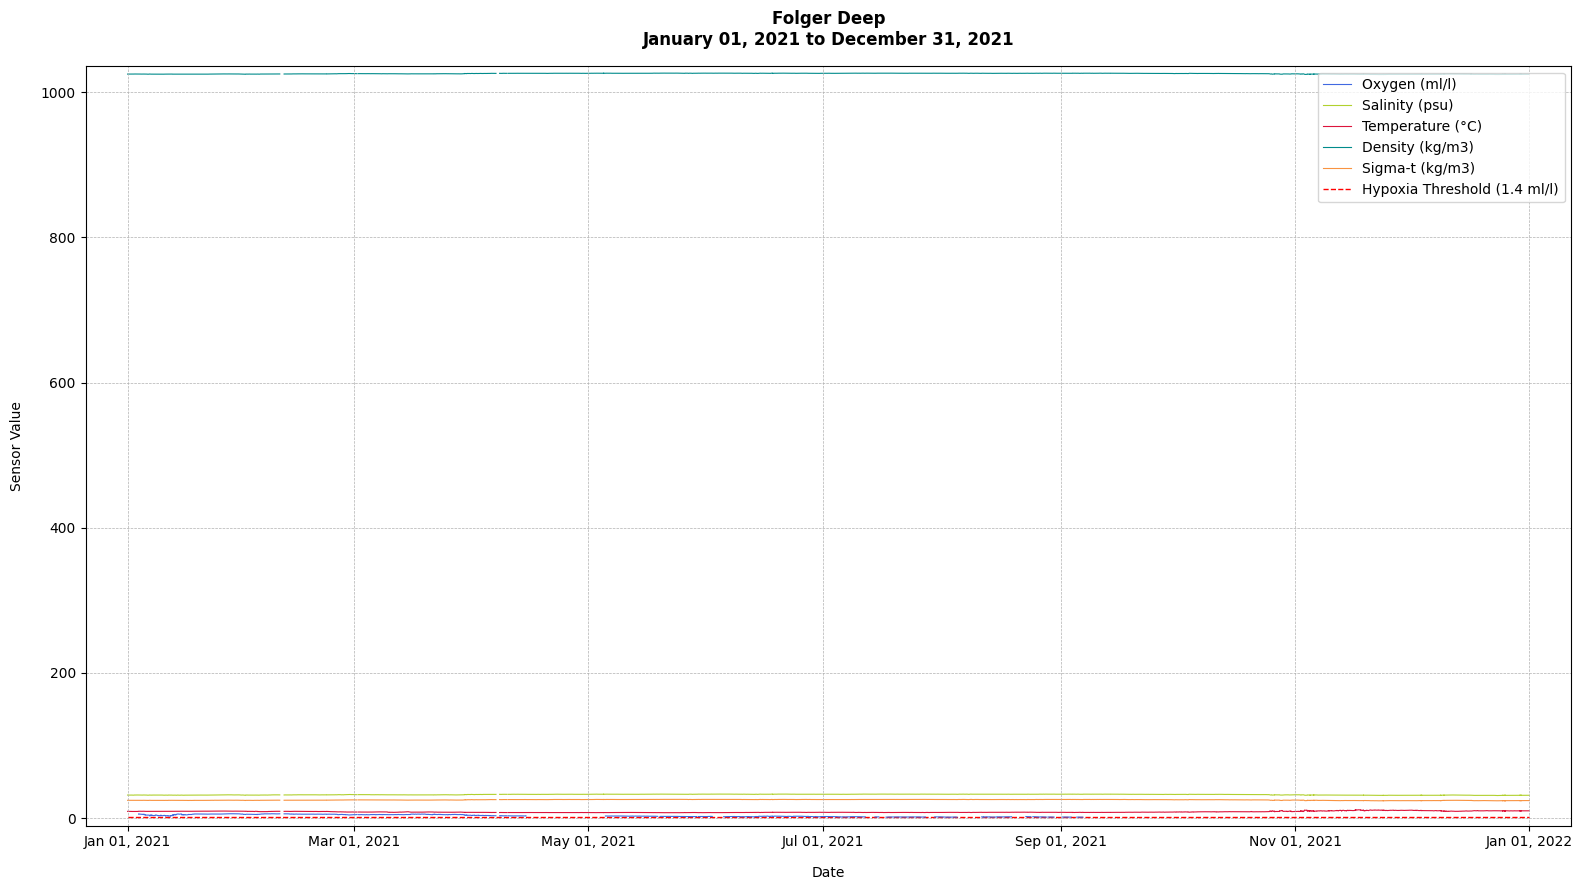

In [10]:
# Refer to BMSC_helpers.py file to understand plot_dataframe function
my_functions.plot_dataframe(df=deep_yr_21_indicators, locationCode=deep_locationCode)

Notice how the absolute scale makes it difficult to view all the parameters together? 

Density is an order of magnitude higher than the others, which obscures any meaningful trends in the data. Let’s address this by exploring alternative approaches to visualizing the data.

2.3.1.1 Option 1: Subplot each property

One way to look at properties with different magnitudes is to subplot each property with an individual y-axis, value, while still sharing an x-axis,  time.

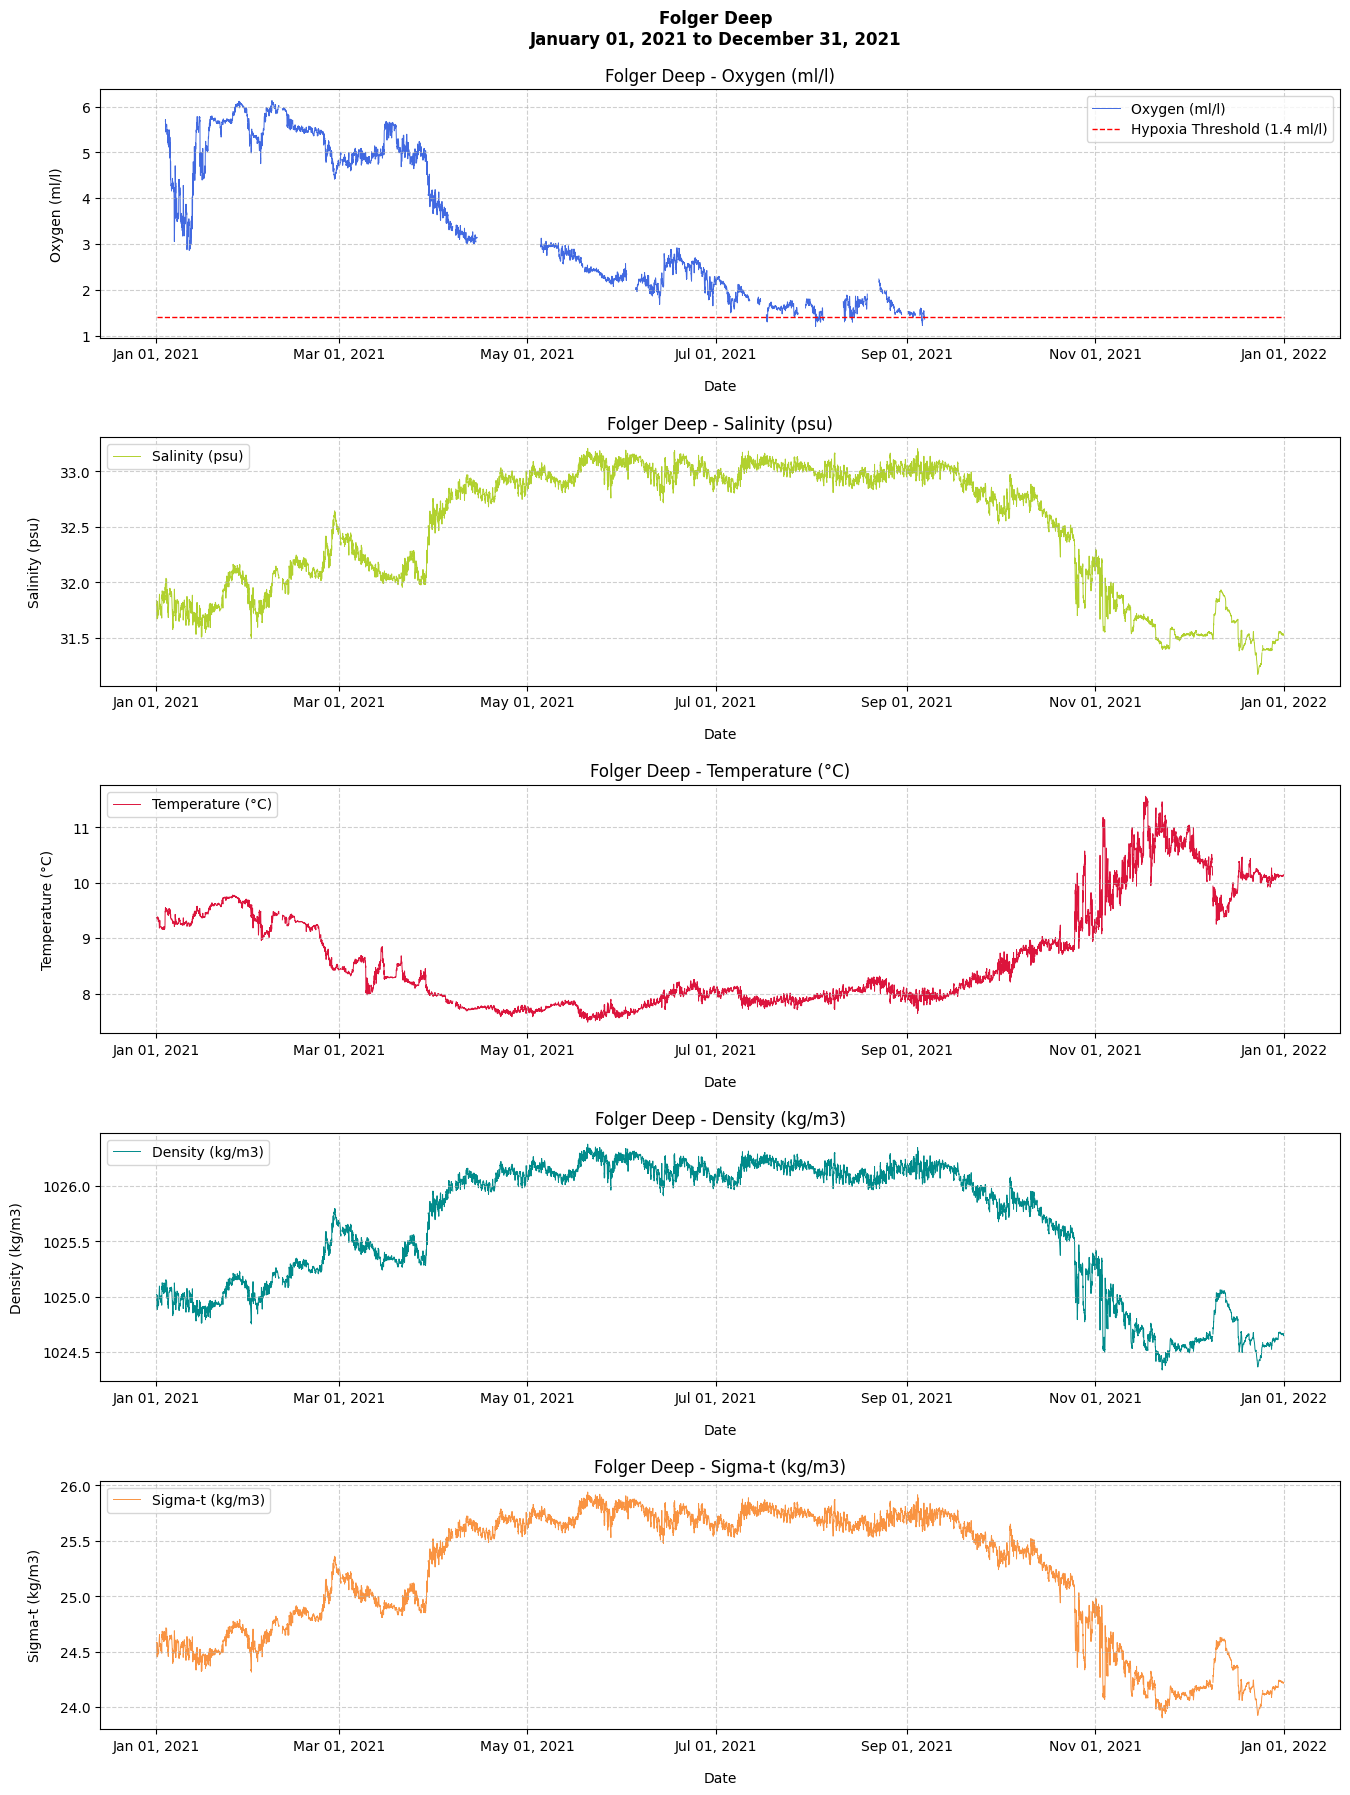

In [11]:
# Refer to BMSC_helpers.py file to understand subplot_all_with_time function
my_functions.subplot_all_with_time(df=deep_yr_21_indicators, locationCode=deep_locationCode)

Notice in the Oxygen plot above, there is a red dashed line at 1.4 ml/l. This indicates a commonly used threshold for low oxygen conditions in a marine environment. 

2.3.1.2 Option 2: Use a twin y-axis for properties of different magnitudes

Another option is to create a twin y-axis for the property with the most different magnitude. In this case, that is density, which now gets its own vertical axis on the right side of the plot, making it easier to compare with other parameters that have smaller scales.

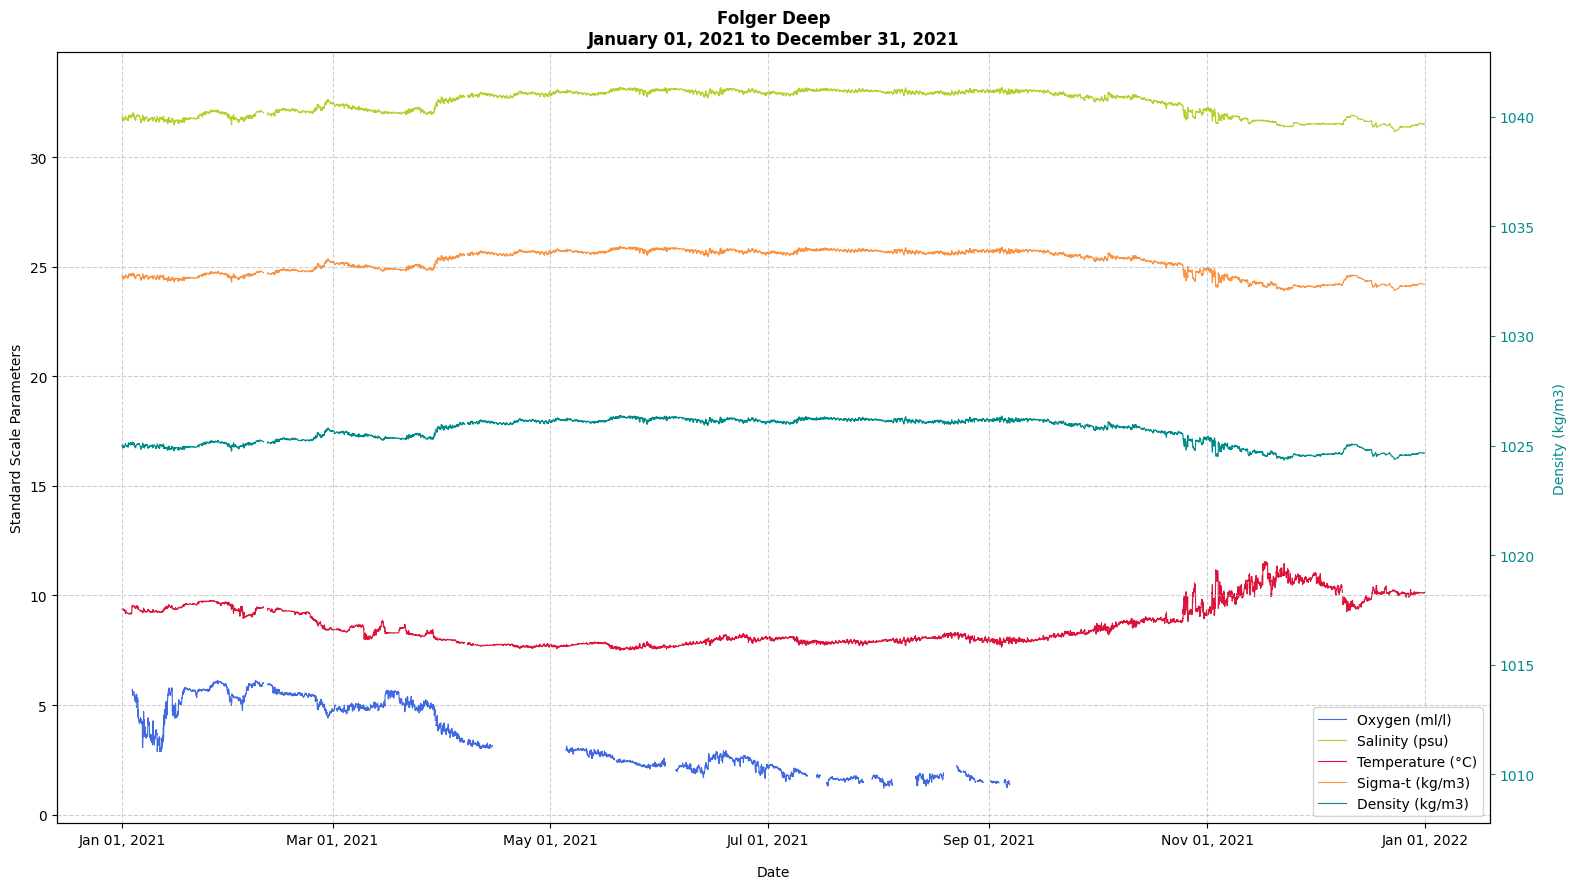

In [12]:
# Refer to BMSC_helpers.py file to understand plot_with_twin_y_axis_for_outlier function
my_functions.plot_with_twin_y_axis_for_outlier(df=deep_yr_21_indicators, locationCode=deep_locationCode)

2.3.1.3 Option 3: Apply oceanographic knowledge

As you might have noticed, our data frame includes both density and sigma t. These two parameters measure the same data except density takes into account atmospheric pressure while sigma t does not. That is: sigma t = density - 1000. 

Thus, sigma t brings the same measurements but at a much lower magnitude, meaning it fits better on the plot with our other parameters. 

Below we remove the density column from our data frame, and plot it accordingly.

In [13]:
# Drop() method removes a column from a data frame
deep_yr_21_indicators.drop("Density (kg/m3)", axis=1, inplace=True) 

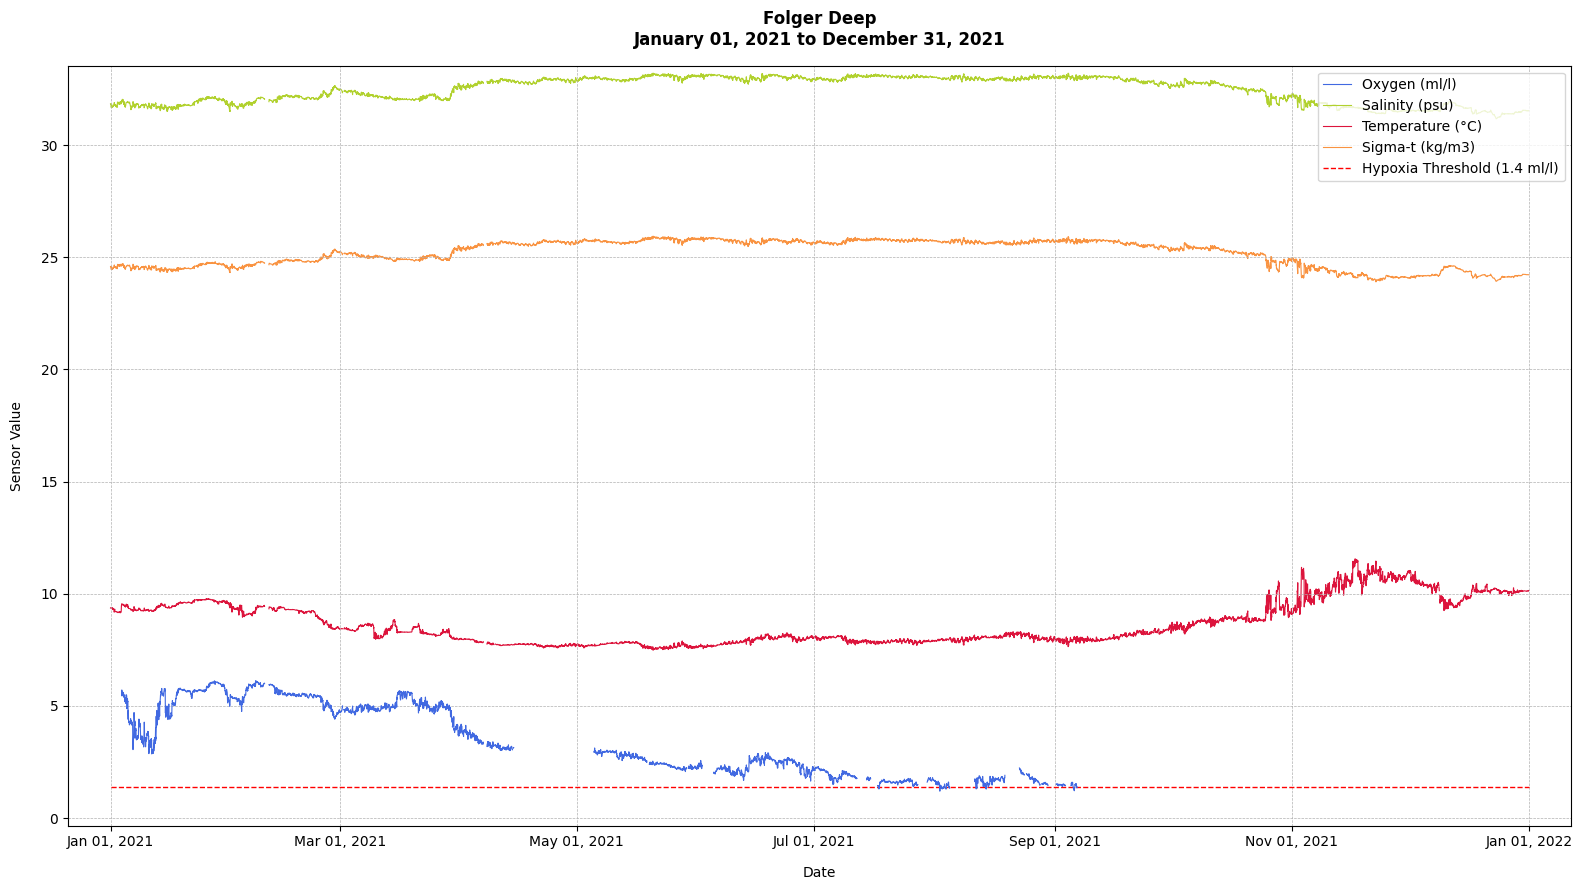

In [14]:
# Refer to BMSC_helpers.py file to understand plot_dataframe function
my_functions.plot_dataframe(df=deep_yr_21_indicators, locationCode=deep_locationCode)

2.3.2 Folger Pinnacle

Now we'll make the same plots for Folger Pinnacle, but you have to fill in some of the parameters. Reference the variables defined in section 1 and the functions used to plot Folger Deep above.

> Enter the name of the Folger Pinnacle data frame and name of the variable storing the Folger Pinnacle location code.

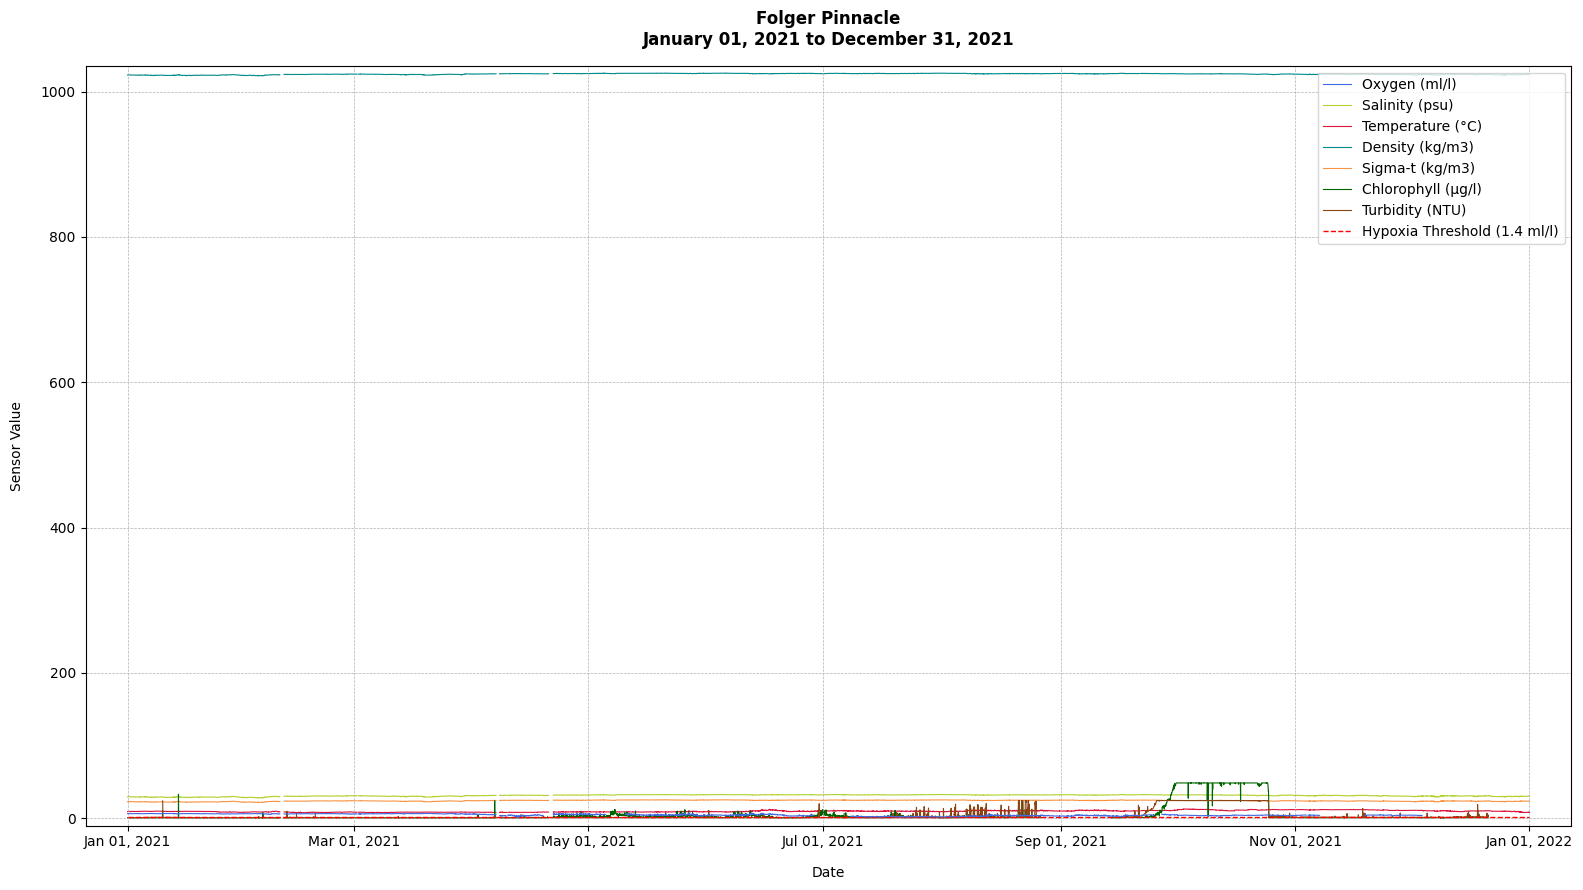

In [15]:
my_functions.plot_dataframe(df=pin_yr_21_indicators, locationCode=pinnacle_locationCode) 
# STUDENT VERSION: my_functions.plot_dataframe(df="DATA FRAME", locationCode="LOCATION CODE") 

2.3.2.1 Option 1: Subplot each property

> Enter the name of the plotting function below. Refer to our plots of Folger Deep above for reference.

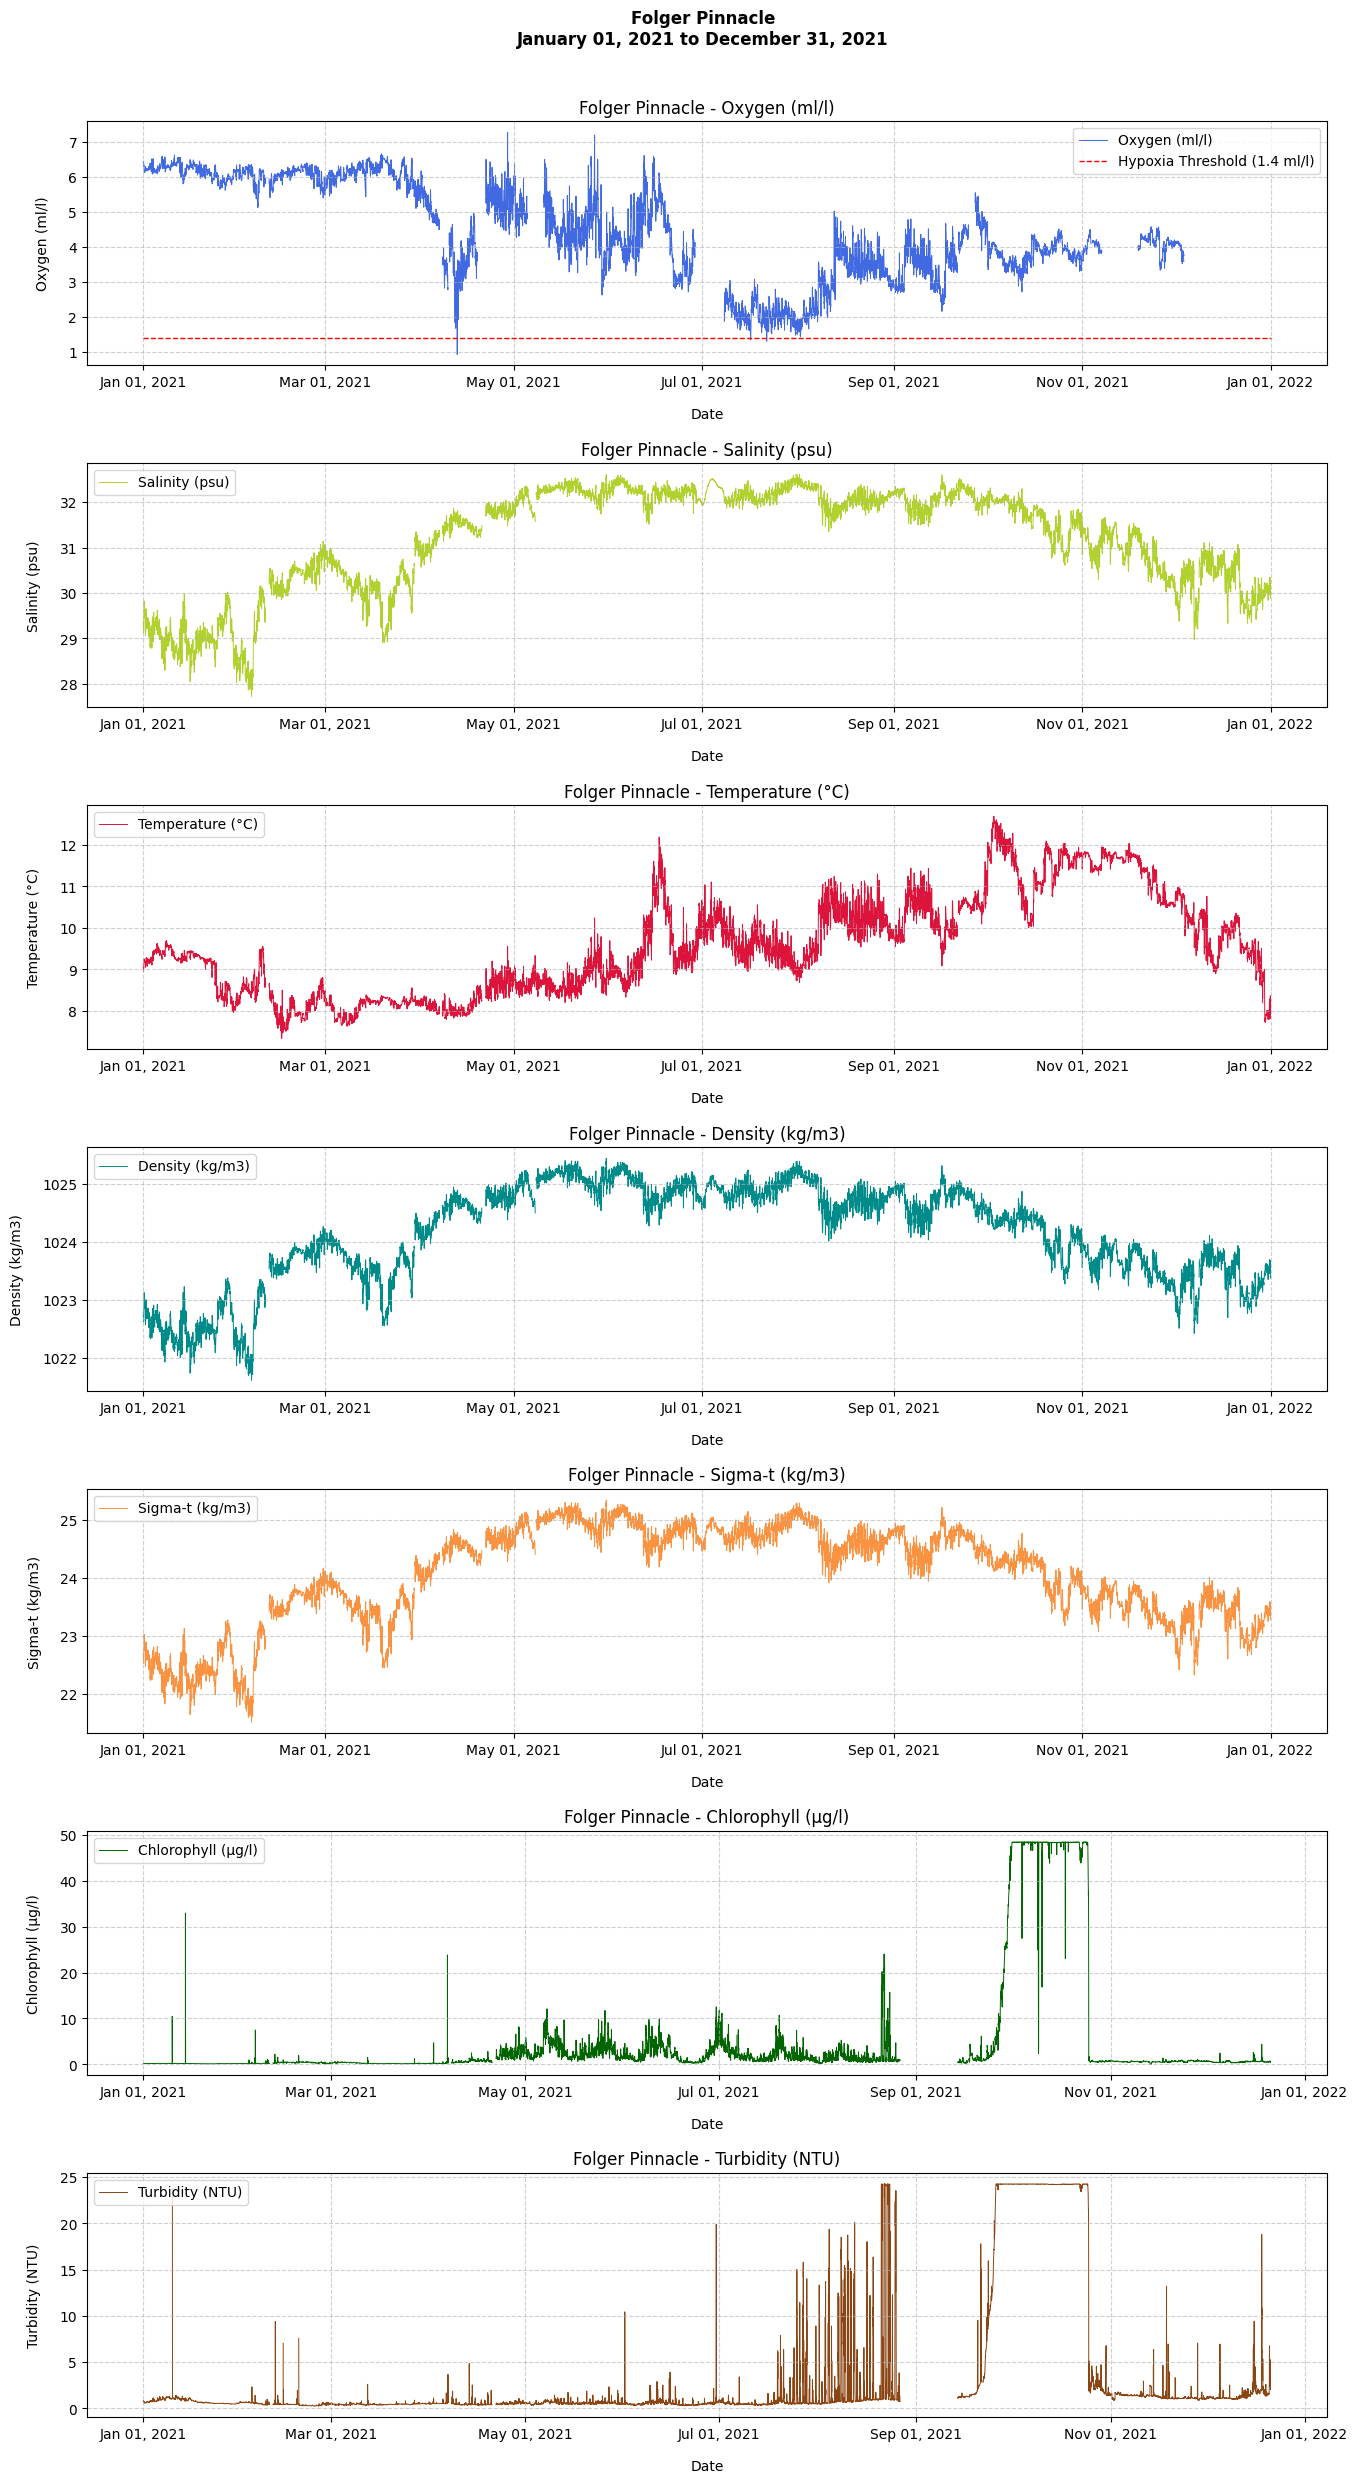

In [16]:
my_functions.subplot_all_with_time(df=pin_yr_21_indicators, locationCode=pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.
# STUDENT VERSION: my_functions."FUNCTION"(df=pin_yr_21_indicators, locationCode=pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.

Looking at the above graphs, consider the following questions:

- Why do you think the chlorophyll started showing up on the sensor in April?

- After chlorophyll readings became very active in May-June, what happened to oxygen?

- Would you expect oxygen to increase or decrease when there is a lot of chlorophyll? Why? 

- Why do you think the temperature was generally warmer in October-November than it was in May-July?

> ANSWER: class discussion

2.3.2.2 Option 2: Use a twin y-axis for properties of different magnitudes

> Enter the name of the plotting function below. Refer to our plots of Folger Deep above for reference.

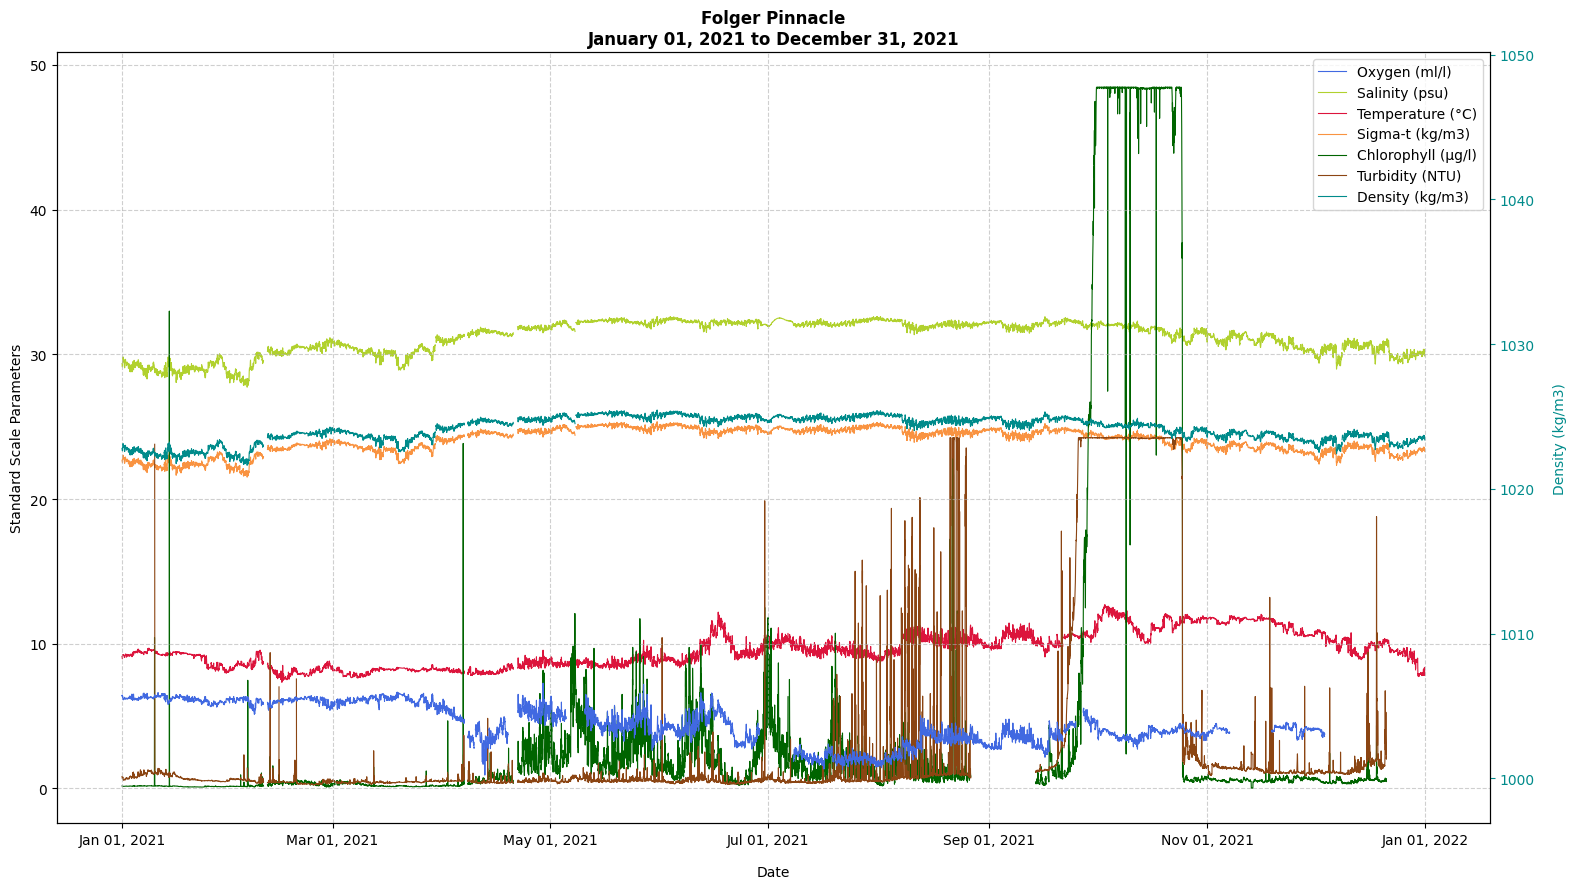

In [17]:
my_functions.plot_with_twin_y_axis_for_outlier(df=pin_yr_21_indicators, locationCode=pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.
# STUDENT VERSION: my_functions."FUNCTION"(df=pin_yr_21_indicators, locationCode=pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.

2.3.2.3 Option 3: Apply oceanographic knowledge

In [18]:
pin_yr_21_indicators.drop("Density (kg/m3)", axis=1, inplace=True) 

> Enter the name of the plotting function below. Refer to our plots of Folger Deep above for reference.

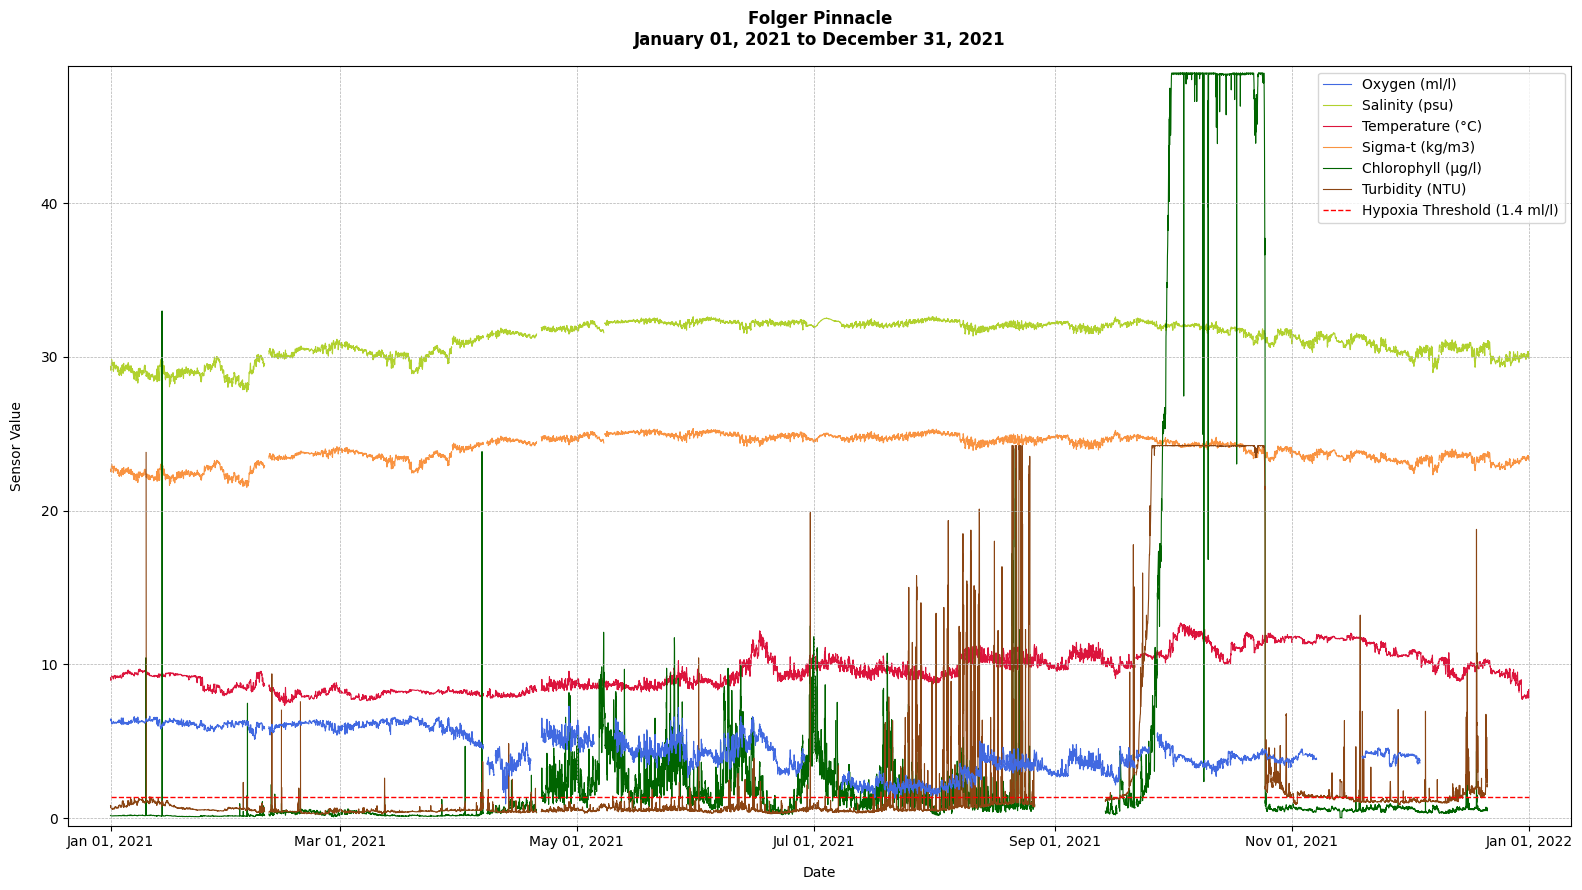

In [19]:
my_functions.plot_dataframe(df=pin_yr_21_indicators, locationCode= pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.
# STUDENT VERSION: my_functions."FUNCTION"(df=pin_yr_21_indicators, locationCode=pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.

### 2.4 Comparing Folger Deep and Folger Pinnacle

We can also compare properties at different depths by sub plotting and overlaying each property at Folger Deep and Folger Pinnacle.

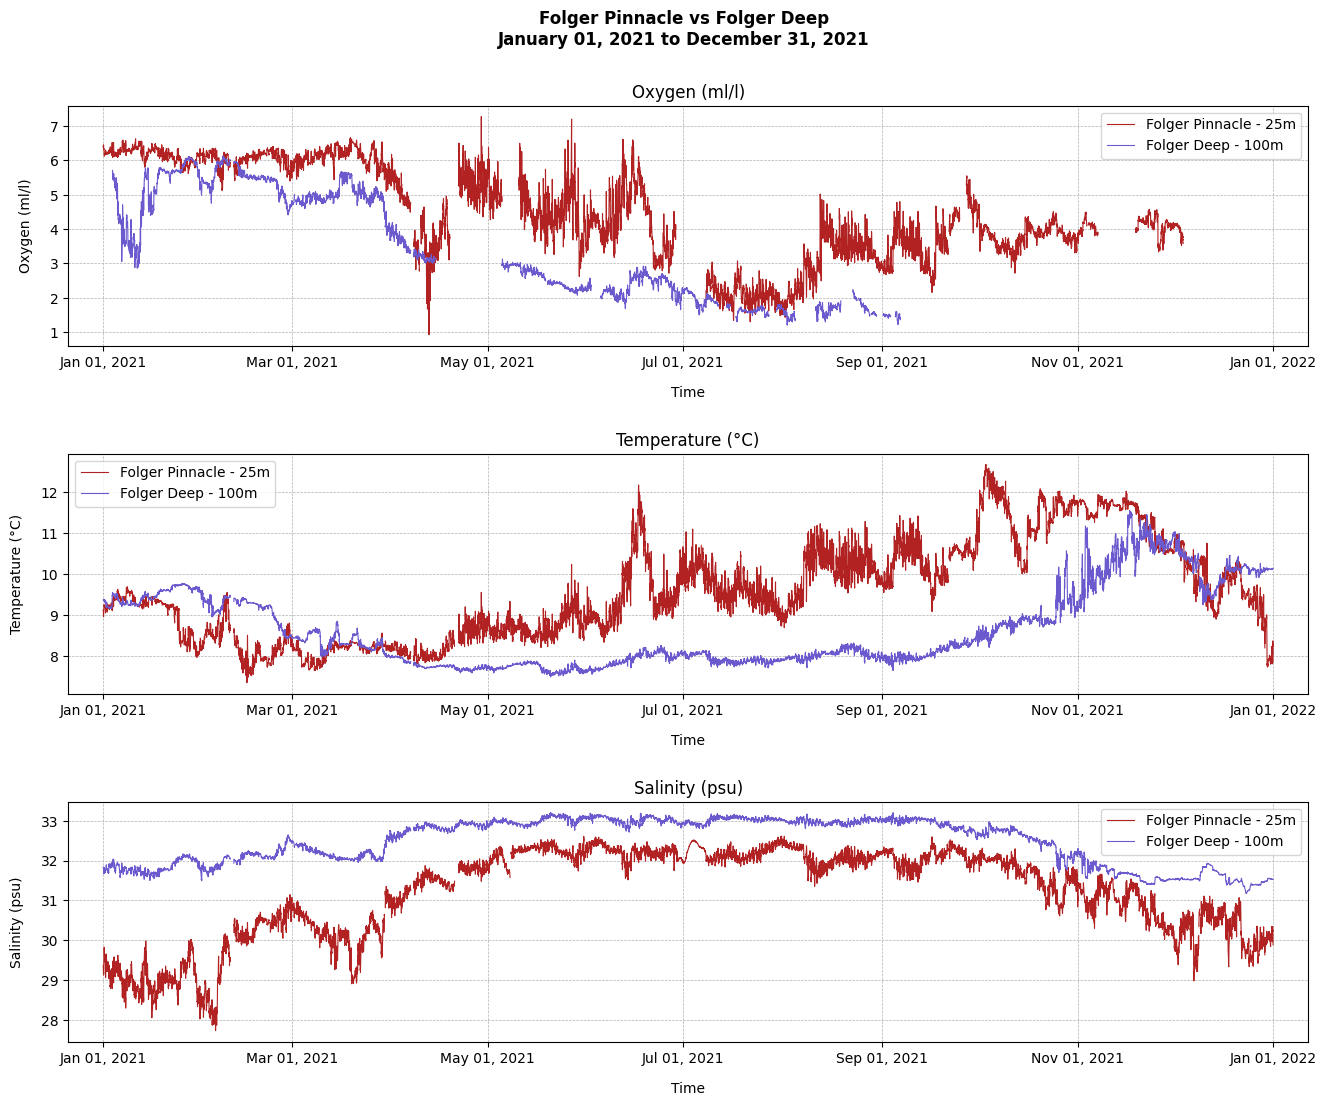

In [20]:
my_functions.compare_sensor_subplots(df1=deep_yr_21_indicators, df2=pin_yr_21_indicators, sensor_cols=["Oxygen (ml/l)", "Temperature (°C)", "Salinity (psu)"], locationCode1=deep_locationCode, locationCode2=pinnacle_locationCode)

Looking at the above plots, consider the following questions:

- Why are oxygen values generally higher at Folger Pinnacle than Folger Deep? What could cause them to be nearly the same (example late July - mid August)?

- Why were Folger Deep temperatures warmer than Folger Pinnacle temperatures during mid January - mid March?

- What could have caused them to be nearly the same in December?

- Why was salinity consistently higher at Folger Deep than Folger Pinnacle?

> ANSWER: class discussion

## 3. Plotting shorter time series

Instead of making repeated API calls, we can use the full-year data frame we already generated to extract smaller time periods of interest. This avoids unnecessary API requests which are time and resource intensive.

### 3.1 Define your shorter time periods

 From looking at the year long plots above we can identify several time periods that would prompt further investigation including:

- Low oxygen - July to September

- High chlorophyll - several times, April through October but let's isolate the autumn period

In [21]:
# Define start and end dates
# July - September
jul_01_str = "2021-07-01T00:00:00.000Z"
sep_01_str = "2021-09-01T00:00:00.000Z"
# Mid September - November
sept_15_str = "2021-09-15T00:00:00.000Z"
nov_01_str = "2021-11-01T00:00:00.000Z"

Note that we must define our dates as strings using the following ISO 8601 UTC format: "YYYY-MM-DDTHH:MM:SS.sssZ".

### 3.2 Convert dates to 'Timestamp' objects

As mentioned above, we use this specific format to define our dates, and then we convert them to Pandas 'Timestamp' objects. This tells the program that each defined date is a moment in time, rather than just text, and is necessary for the next step.

In [22]:
# Convert string dates to pandas Timestamps
# July - September
jul_01 = pd.to_datetime(jul_01_str)
sep_01 = pd.to_datetime(sep_01_str)
# Mid September - November
sept_15 = pd.to_datetime(sept_15_str)
nov_01 = pd.to_datetime(nov_01_str)

### 3.3 Create new Data Frames by 'slicing' the original one

Now that the timestamps are defined, we use them to 'slice' specific time-based subsets of the full data frame. This is done using 'dataframe.loc[start:stop]', which selects only the rows from the data frame that fall between two dates.

Below, is an example of an initial data frame, with the red box outlining the start and end times where we slice it, according to the following code:

             deep_yr_21_indicators.loc["2021-01-01T04:00:00.000Z":"2021-01-01T08:00:00.000Z"]

We then see the new data frame this command produces.

<img src="original_dataframe.png" width="" align="" />

<img src="new_dataframe.png" width="" align="" />

Following this same technique, we can isolate our periods of interest.

In [23]:
# Deep: Slice views of the full-year data
deep_low_ox_df = deep_yr_21_indicators.loc[jul_01:sep_01]
deep_high_chlor_df = deep_yr_21_indicators.loc[sept_15:nov_01]

# Pinnacle: Slice views of the full-year data
pin_low_ox_df = pin_yr_21_indicators.loc[jul_01:sep_01]
pin_high_chlor_df = pin_yr_21_indicators.loc[sept_15:nov_01]

### 3.4 Plot using Data Frames

And now that we have our specific periods, we can plot them just like we would our original data frame. Let's start with July to September.

#### 3.4.1 Low Oxygen (July to September)

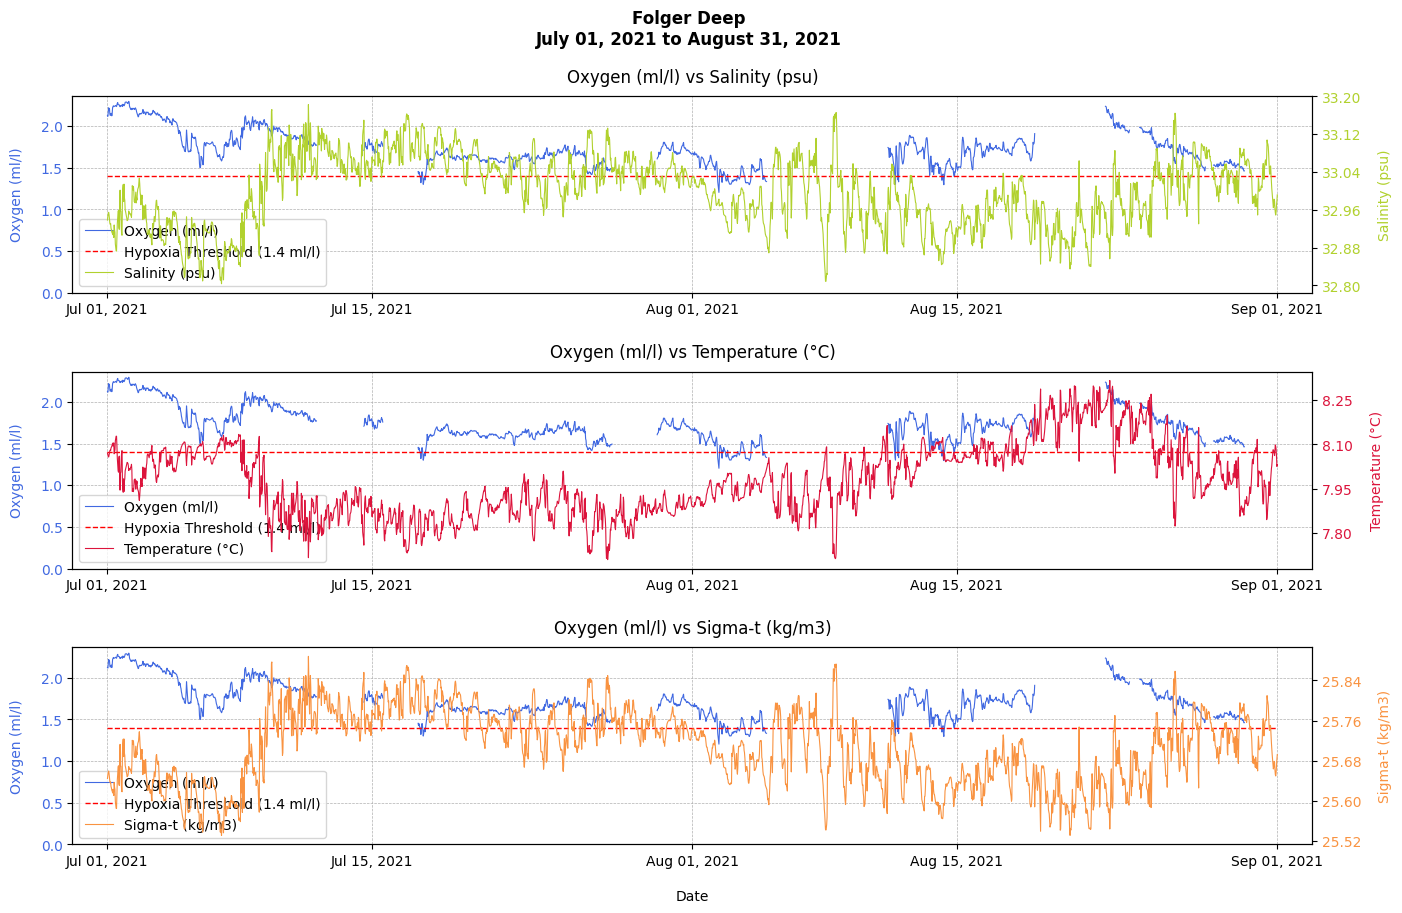

In [24]:
my_functions.subplot_all_with_oxygen(df=deep_low_ox_df, locationCode=deep_locationCode)

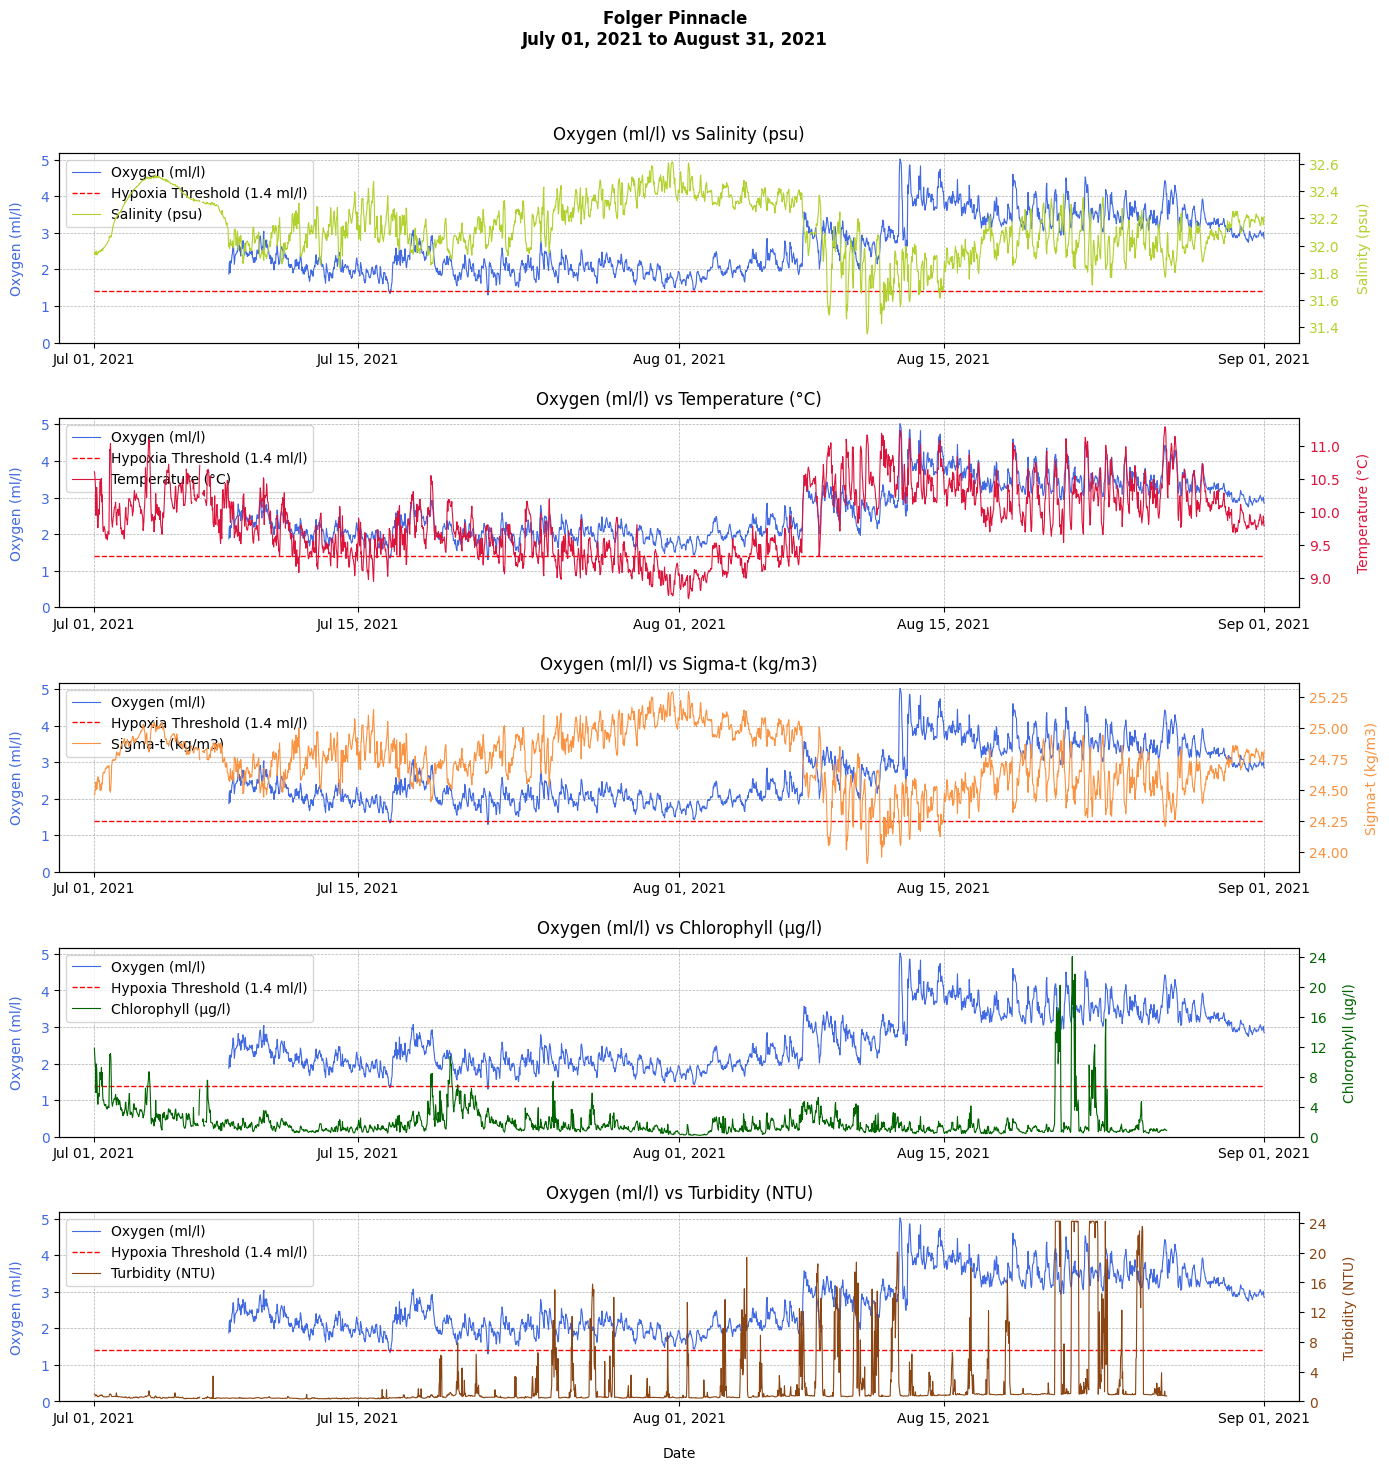

In [25]:
my_functions.subplot_all_with_oxygen(df=pin_low_ox_df, locationCode=pinnacle_locationCode)

### 3.5 Interpreting the Graphs

Looking at the above graphs, consider the following questions:

- How would you describe the relationship between salinity and oxygen? Why do we see a reversal in these properties over the course of the plot?

- Which parameter aligns most closely with oxygen? Why do you think they are closely aligned?

- Do you see any obvious correlations between oxygen and chlorophyll? 

- Oxygen and turbidity?

> ANSWER: In the above plot, when salinity is higher, oxygen is lower and vice-versa. But this is not always the case. Here there seems to be a correlation (not causal relationship). We suspect upwelling is bringing saltier, lower oxygen to the surface...

## 4. High Chlorophyll? (September to November)

Now, lets plot using the other new data frame we created - this one is for mid September to November. 

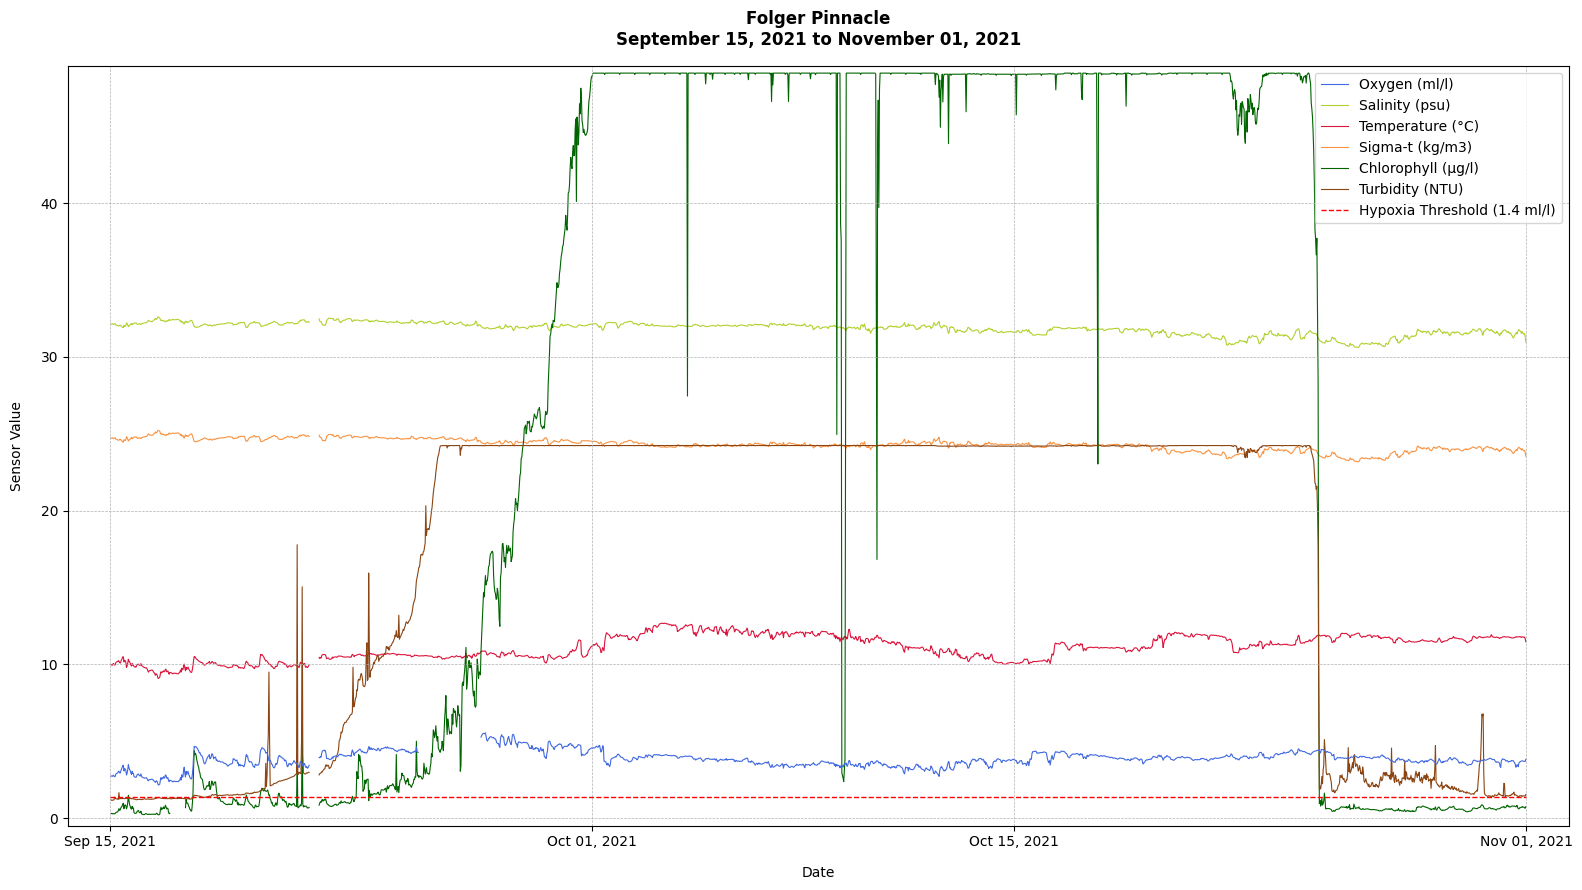

In [26]:
my_functions.plot_dataframe(df=pin_high_chlor_df, locationCode=pinnacle_locationCode, start=sept_15, end=nov_01)

Why did both the chlorophyll and turbidity curves go flat after reaching a high value? What could have caused the chlorophyll and turbidity to reach such high values at this time of year? Does it make sense for a phytoplankton bloom to happen in this area during late September and October?

> ANSWER: Flat at the top because they reached the top of the sensor range. High values due to possible growth of an organism near a sensor, but normally we would not expect such high values at this time of year. Rather we would expect them in spring and summer.

The following photos show the Folger Pinnacle 3D camera array before deployment in 2010 (left) and after a year in the water (right). Does this photo give you any further ideas about what may have been happening with the chlorophyll and turbidity sensors? Consider and discuss as a class.

<img src="folger_camera_array_2010_2011.png" width="" align="" />

## 5. Oxygen Profile offshore from Folger

The following plot was created by combining a series of vertical casts (18 August 2021) from offshore (near 400 m deep) to inshore (100 m deep). You can see the locations of the casts as black dots on the map below. Looking at the section of dissolved oxygen (DO), notice the very low oxygen values indicated by purple shades with the red 1.4 ml/l contour.

<img src="oxygen-profile-plots.jpeg" width="" align="" />

Variations in CTD and oxygen records for Folger Deep (100m) have strong linkages with the regional upwelling and downwelling signals. The cold, salty upwelling season in 2021 started on 21 March, over a full month ahead of the climatological mean of April 26. This upwelling was sustained for over 6 months. Low oxygen conditions were observed as early as April in 2021. “Low dissolved oxygen levels have become the norm ion the Pacific Northwest coast, but this event started much earlier than we’ve seen in our records,” said Oregon State University Professor Francis Chan, director of the NOAA cooperative institute CIMERS. “This is the earliest start to the upwelling season in 35 years.” Typically, hypoxic conditions don’t appear until  late June or early July, he said. (Source article.)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cd2cd01-70e8-41b6-af2d-f797c6675dbe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>